In [1]:
#!pip install einops

In [2]:
!pip install torchvision --upgrade

     |████████████████████████████████| 24.2 MB 624 kB/s eta 0:00:01
     |████████████████████████████████| 887.5 MB 4.3 kB/s  eta 0:00:01     |█████▎                          | 146.6 MB 67.3 MB/s eta 0:00:12     |███████████████▊                | 436.8 MB 60.2 MB/s eta 0:00:08     |████████████████                | 444.0 MB 60.2 MB/s eta 0:00:08     |████████████████████████▎       | 673.9 MB 28.8 MB/s eta 0:00:08     |█████████████████████████       | 692.0 MB 28.8 MB/s eta 0:00:07ta 0:00:03     |█████████████████████████████▍  | 815.9 MB 31.2 MB/s eta 0:00:03     |█████████████████████████████▌  | 817.6 MB 31.2 MB/s eta 0:00:03     |█████████████████████████████▋  | 822.0 MB 31.2 MB/s eta 0:00:03     |████████████████████████████████| 885.4 MB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 21.0 MB 44.6 MB/s eta 0:00:01     |████████████████████████████████| 21.0 MB 44.6 MB/s 
     |████████████████████████████████| 317.1 MB 24 kB/s s eta 0:00:01 MB/s eta 0:02:14     

In [3]:
import cv2
import os
import math
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from torch.nn import Transformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch import Tensor
from PIL import Image
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(442)

In [4]:
class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
        
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        
        #staring index 4
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX= 3,0,1,2

In [5]:
image_path = "../input/ucm-dataset/UCMDATA/imgs/"
dir_text = "../input/ucm-dataset/UCMDATA/filenames/descriptions_UCM.txt"
train_imgs_txt_path="../input/ucm-dataset/UCMDATA/filenames/filenames_train.txt"
val_imgs_txt_path="../input/ucm-dataset/UCMDATA/filenames/filenames_val.txt"
test_imgs_txt_path="../input/ucm-dataset/UCMDATA/filenames/filenames_test.txt"
jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 2100


In [6]:
file = open(dir_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split(' ')
    filenumber=col[0]
    caption=' '.join(col[1:])
    img=filenumber+'.tif'
    datatxt.append([filenumber]+[img]+[caption])
data = pd.DataFrame(datatxt,columns=["img_number","img","caption"])

uni_filenames = np.unique(data.img.values)
data.head(10)

,img_number,img,caption
0,1,1.tif,there is a piece of farmland
1,1,1.tif,there is a piece of cropland
2,1,1.tif,it is a piece of farmland
3,1,1.tif,it is a piece of cropland
4,1,1.tif,here is a piece of farmland
5,2,2.tif,there is a piece of farmland
6,2,2.tif,there is a piece of cropland
7,2,2.tif,it is a piece of farmland
8,2,2.tif,it is a piece of cropland
9,2,2.tif,here is a piece of farmland


In [7]:
train_imgs_number_vector=[]
file = open(train_imgs_txt_path,'r')
text = file.read()
file.close()
for line in text.split('\n'):
    col = line.split('.')
    filenumber=col[0]
    train_imgs_number_vector.append(filenumber)
train_captions = []
train_nb=[]
for nb in train_imgs_number_vector:
    train_data=data[data["img_number"]==nb]
    for caption  in train_data["caption"].astype(str):
        train_captions.append(caption)
        train_nb.append(nb)

In [8]:
test_imgs_number_vector=[]
file = open(test_imgs_txt_path,'r')
text = file.read()
file.close()
for line in text.split('\n'):
    col = line.split('.')
    filenumber=col[0]
    test_imgs_number_vector.append(filenumber)
test_captions = []
test_dict={}
for nb in test_imgs_number_vector:
    test_data=data[data["img_number"]==nb]
    for caption  in test_data["caption"].astype(str):
        l_capt=caption.split()
        if nb in test_dict.keys():
            test_dict[nb].append(l_capt)
        else:
            test_dict[nb]=[l_capt]

In [9]:
val_imgs_number_vector=[]
file = open(val_imgs_txt_path,'r')
text = file.read()
file.close()
for line in text.split('\n'):
    col = line.split('.')
    filenumber=col[0]
    val_imgs_number_vector.append(filenumber)
val_dict={}
for nb in val_imgs_number_vector:
    val_data=data[data["img_number"]==nb]
    for caption  in val_data["caption"].astype(str):
        l_capt=caption.split()
        if nb in val_dict.keys():
            val_dict[nb].append(l_capt)
        else:
            val_dict[nb]=[l_capt]
val_captions = []
val_nb=[]
for nb in val_imgs_number_vector:
    val_data=data[data["img_number"]==nb]
    for caption  in val_data["caption"].astype(str):
        val_captions.append(caption)
        val_nb.append(nb)

In [10]:
freq_threshold=1
vocab= Vocabulary(freq_threshold)
vocab.build_vocab(train_captions+val_captions)
len(vocab)

333

In [11]:
def Patch_extract(img_nb):
    imga_locationa =image_path+img_nb+'.tif'
    imga = cv2.imread(imga_locationa)
    imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
    transf=T.Compose([T.ToTensor(),T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),T.Resize(224)])
    imga=transf(imga)
    return imga  

In [12]:
class BuildingChangedataset(Dataset):

    def __init__(self,train_nb,train_captions,vocab,transform=None):
        self.transform = transform
        #Get image and caption colum from the dataframe
        self.imgs = train_nb
        self.captions = train_captions
        self.p=Patch_size
        #Initialize vocabulary and build vocab
        self.vocab = vocab
        
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_nb = self.imgs[idx]
        
        imga_locationa =image_path+img_nb+'.tif'
        imga = cv2.imread(imga_locationa)
        imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
        #apply the transfromation to the image
        if self.transform is not None:
            imga = self.transform(imga)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        transf=T.Compose([T.ToTensor(),T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),T.Resize(224)])
        imga=transf(imga)
        return img_nb,imga,torch.tensor(caption_vec)    
    
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.batch_first = batch_first
    
    def __call__(self,batch):
        img_batch,cap_batch=[],[]
        for img_nb,img,cap in batch:
            img_batch.append(img)
            cap_batch.append(cap)
        cap_batch=pad_sequence(cap_batch, padding_value=PAD_IDX)
        img_batch=pad_sequence(img_batch,padding_value=PAD_IDX)
        return img_nb,img_batch,cap_batch


def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader


In [13]:
class EncoderCNN(nn.Module):
    def __init__(self,emb_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        resnet.fc = nn.Identity()
        resnet.avgpool=nn.Identity()
        self.resnet=resnet
        for param in self.resnet.parameters():
            param.requires_grad_(True)
        self.conv=nn.Conv2d(2048,emb_size,1)
    def forward(self, images):
        images=images.permute(1,0,2,3)
        features = self.resnet(images) #(batch_size,2048,7,7)
        features=features.view(images.shape[0],2048,7,7)
        features= self.conv(features)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1))
        features = features.permute(1,0,2) 
        return features

In [14]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        tok=tokens.permute(1,0)
        tok=self.embedding(tok.long()) * math.sqrt(self.emb_size)
        tok=tok.permute(1,0,2)
        return tok
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 patch_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.0):
        super(Seq2SeqTransformer, self).__init__()
        self.encoder_cnn=EncoderCNN(emb_size)
        decoder_layer= nn.TransformerDecoderLayer(emb_size, nhead,dim_feedforward,dropout,"gelu")
        self.decoder=nn.TransformerDecoder(decoder_layer, num_decoder_layers, norm=None)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = nn.Linear(patch_size*patch_size*3,emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb=self.encoder_cnn(src)
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs=self.decoder(tgt_emb,src_emb,tgt_mask)
        outs=self.generator(outs)
        return outs

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.encoder_cnn(src)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.decoder(tgt_emb,memory)

In [15]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [16]:
def beam_search(model, src, src_mask, max_len, start_symbol,k):
    model.eval()
    src = src.to(DEVICE)
    src_mask = src_mask

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if (i==0):
            new_ys=[]
            new_probas=[]
            tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            proba=nn.Softmax(dim=1)
            prob=proba(prob)
            p_words, words = torch.topk(prob,k)
            for word in words[0].tolist():
                new_ys.append(torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(word)], dim=0))
            for word_proba in p_words[0]:
                new_probas.append( torch.log(word_proba ) )
        else:
            new_ys,new_probas=decode_next(model,memory,src,k,new_probas,new_ys)
        c = 0
        for y in new_ys:
            if( y.tolist()[-1][0] == EOS_IDX):
                c=c+1
        if (c==k):
            return new_ys,new_probas
    return new_ys,new_probas
        
def decode_next(model,memory,src,k,probas,word_seqs):
    new_word_seqs,new_seq_probas=[],[]
    normalized_seq_probas=[]
    for i in range(k):
        past_proba=probas[i]
        past_word_seq=word_seqs[i]
        if ( past_word_seq.tolist()[-1][0] == EOS_IDX ):
            new_seq_probas.append(past_proba)
            new_word_seqs.append(past_word_seq)
        else :
            tgt_mask = (generate_square_subsequent_mask(past_word_seq.size(0))
                        .type(torch.bool)).to(DEVICE)
            out = model.decode(past_word_seq, memory, tgt_mask)
            out = out.transpose(0, 1)
            scores = model.generator(out[:, -1])
            to_proba=nn.Softmax(dim=1)
            proba=to_proba(scores)
            words_proba, words = torch.topk(proba,k,dim=1)
            for word in words[0].tolist():
                seq=torch.cat([past_word_seq,torch.ones(1, 1).type_as(src.data).fill_(word).to(DEVICE)], dim=0)
                new_word_seqs.append(seq)
            for word_proba in words_proba[0]:
                seq_proba=torch.log(word_proba)+past_proba
                new_seq_probas.append(seq_proba)
    new_seq_probas=torch.tensor(new_seq_probas)
    for j in range(len(new_word_seqs)):
        normalized_seq_probas.append( new_seq_probas[j]/(len(new_word_seqs[j])) )
    _,indexes=torch.topk(torch.tensor(normalized_seq_probas),k,dim=0)
    topk_seq,topk_probas=[],[]
    for idx in indexes:
        topk_seq.append(new_word_seqs[idx])
        topk_probas.append(new_seq_probas[idx])
    return topk_seq,topk_probas
def translate_beam(model: torch.nn.Module, nb):
    model.eval()
    src=(torch.FloatTensor(Patch_extract(nb))).unsqueeze(1)
    src_mask = None
    topk_seq,topk_probas = beam_search(transformer, src, None,40, BOS_IDX,3)
    top_seq=topk_seq[0].flatten()
    caption_predicted=[vocab.itos[token] for token in top_seq.tolist()]
    caption_predicted=" ".join(caption_predicted).replace("<SOS>", "").replace("<EOS>", "")
    caption_predicted=caption_predicted.rstrip()
    return caption_predicted

In [17]:
# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys
def translate(model: torch.nn.Module, nb):
    model.eval()
    src=(torch.FloatTensor(Patch_extract(nb))).unsqueeze(1)
    src_mask = None
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=70, start_symbol=BOS_IDX).flatten()
    caption_predicted=[vocab.itos[token] for token in tgt_tokens.tolist()]
    caption_predicted=" ".join(caption_predicted).replace("<SOS>", "").replace("<EOS>", "")
    caption_predicted=caption_predicted.rstrip()
    return caption_predicted


In [18]:
import torchmetrics
bleu1=torchmetrics.BLEUScore(n_gram=1)
bleu2=torchmetrics.BLEUScore(n_gram=2)
bleu3=torchmetrics.BLEUScore(n_gram=3)
bleu4=torchmetrics.BLEUScore(n_gram=4)
def evaluate_bleu_img(model,nb,test_dict):
    real_captions =[test_dict[nb]]
    caption_predicted= [translate_beam(model,nb).split()]
    score1 =bleu1(real_captions,caption_predicted)
    score2 =bleu2(real_captions,caption_predicted)
    score3 =bleu3(real_captions,caption_predicted)
    score4 =bleu4(real_captions,caption_predicted)
    return score1,score2,score3,score4,real_captions,caption_predicted
def evaluate_bleu_dataset(model,test_dict):
    avg_sc1=0
    avg_sc2=0
    avg_sc3=0
    avg_sc4=0
    for nb in test_dict.keys():
        score1,score2,score3,score4,references,candidate=evaluate_bleu_img(model,nb,test_dict)
        avg_sc1+=score1
        avg_sc2+=score2
        avg_sc3+=score3
        avg_sc4+=score4
    avg_sc1/=len(test_dict.keys())
    avg_sc2/=len(test_dict.keys())
    avg_sc3/=len(test_dict.keys())
    avg_sc4/=len(test_dict.keys())
    return float(avg_sc1),float(avg_sc2),float(avg_sc3),float(avg_sc4)

# Train

In [19]:
Patch_size = 16
TGT_VOCAB_SIZE = len(vocab)
EMB_SIZE = 512
NHEAD = 16
FFN_HID_DIM = 512*4
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 12
NUM_DECODER_LAYERS = 3
Dropout=0.1
train_dataset=BuildingChangedataset(train_nb,train_captions,vocab)
val_dataset=BuildingChangedataset(val_nb,val_captions,vocab)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, Patch_size, TGT_VOCAB_SIZE, FFN_HID_DIM,Dropout)


transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00003, betas=(0.9, 0.98), eps=1e-9)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [20]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    metric = torchmetrics.Accuracy()
    train_dataloader = get_data_loader(train_dataset,BATCH_SIZE,shuffle=True,num_workers=1)
    for imgnb,src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_padding_mask=None
        src_mask=None
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        loss.backward()

        optimizer.step()
        losses += loss.item()
        acc = metric((logits.reshape(-1, logits.shape[-1])).cpu(), (tgt_out.reshape(-1)).cpu())
    acc = metric.compute()
    return losses / len(train_dataloader),acc


def evaluate(model):
    model.eval()
    losses = 0
    val_dataloader = get_data_loader(val_dataset,BATCH_SIZE,shuffle=True,num_workers=1)
    metric = torchmetrics.Accuracy()
    for imgnb,src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
  
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_padding_mask=None
        src_mask=None
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        acc = metric(logits.reshape(-1, logits.shape[-1]).cpu(), tgt_out.reshape(-1).cpu())
    acc = metric.compute()
    return losses / len(val_dataloader),acc

In [21]:
from timeit import default_timer as timer
NUM_EPOCHS = 4
min_val=100
best_ep=0
max_sc=0
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss,train_acc = train_epoch(transformer, optimizer)
    val_loss,val_acc = evaluate(transformer)
    end_time = timer()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc: {train_acc*100:.3f},Val acc: {val_acc*100:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
    sc1,sc2,sc3,sc4=evaluate_bleu_dataset(transformer,val_dict)
    print((f"Bleu1 :{sc1*100:.2f}, Bleu2 :{sc2*100:.2f}, Bleu3 :{sc3*100:.2f}, Bleu4 :{sc4*100:.2f}" ))
    if ( sc4+sc1*0.5 > max_sc  ):
        max_sc=sc4+sc1*0.5 
        torch.save(transformer.state_dict(), "best_transformer")
        print("Model saved!")
        best_ep=epoch
    print("_______")
    torch.save(transformer.state_dict(), "last_transformer")

Epoch: 1, Train loss: 2.062, Val loss: 1.172, Train acc: 37.537,Val acc: 45.469 Epoch time = 109.599s
Bleu1 :80.00, Bleu2 :75.20, Bleu3 :69.14, Bleu4 :63.20
Model saved!
_______
Epoch: 2, Train loss: 0.795, Val loss: 0.932, Train acc: 50.900,Val acc: 47.905 Epoch time = 103.032s
Bleu1 :83.12, Bleu2 :77.39, Bleu3 :71.34, Bleu4 :62.47
Model saved!
_______
Epoch: 3, Train loss: 0.565, Val loss: 0.914, Train acc: 53.861,Val acc: 48.056 Epoch time = 102.870s
Bleu1 :84.73, Bleu2 :78.94, Bleu3 :72.85, Bleu4 :65.20
Model saved!
_______
Epoch: 4, Train loss: 0.459, Val loss: 0.918, Train acc: 55.184,Val acc: 48.850 Epoch time = 103.149s
Bleu1 :85.44, Bleu2 :79.55, Bleu3 :73.92, Bleu4 :66.83
Model saved!
_______


In [22]:
transformer.load_state_dict(torch.load("./best_transformer"))
evaluate_bleu_dataset(transformer,test_dict)

(0.8399025201797485,
 0.7850779294967651,
 0.7330700159072876,
 0.6774030923843384)

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : it is a straight runway with some mark lines on it
Real Caption  2 : a straight runway with some mark lines on it
Real Caption  3 : there are some mark lines on the straight runway
Real Caption  4 : it is a straight runway with some white mark lines on it
Real Caption  5 : a straight runway with some white mark lines on it
Predicted Caption: a straight runway with some white mark lines on it


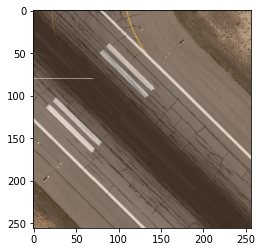

BLEU-1 score: 75.0
BLEU-2 score: 67.08203887939453
BLEU-3 score: 57.775699615478516
BLEU-4 score: 52.18739318847656
Real Caption  1 : an overpass go across the roads diagonally
Real Caption  2 : an overpass cross the roads diagonally with some cars on the roads
Real Caption  3 : an overpass go across the roads diagonally with some plants surounded
Real Caption  4 : an overpass cross the roads diagonally with some cars on the roads
Real Caption  5 : an overpass go across the roads with some cars on the roads
Predicted Caption: an overpass with a road go across another roads diagonally with some cars on the roads


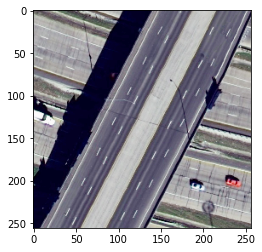

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : many mobile homes arranged in lines with some cars parked at the roadside in the mobile home park
Real Caption  2 : many mobile homes are closed to each other in the mobile home park
Real Caption  3 : lots of mobile homes with plants surrounded in the mobile home park
Real Caption  4 : many mobile homes arranged in lines in the mobile home park and some roads go through this area
Real Caption  5 : lots of mobile homes are closed to each other and some roads go through this area
Predicted Caption: many mobile homes arranged in lines in the mobile home park and some roads go through this area


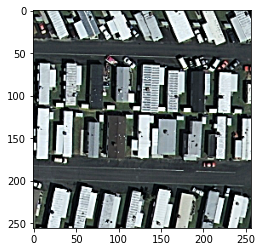

BLEU-1 score: 71.1766586303711
BLEU-2 score: 59.683441162109375
BLEU-3 score: 43.355403900146484
BLEU-4 score: 32.29365539550781
Real Caption  1 : this is a dense forest with green and dark green plants
Real Caption  2 : lots of green and dark green plants constitute a dense forest
Real Caption  3 : there are lots of green and dark green plants in the dense forest
Real Caption  4 : there are lots of green plants and dotted with some dark green plants
Real Caption  5 : there are lots of green plants
Predicted Caption: lots of dark green trees constitute a dense forest


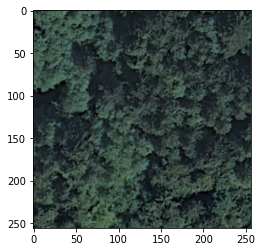

BLEU-1 score: 76.92308044433594
BLEU-2 score: 66.98641204833984
BLEU-3 score: 54.644561767578125
BLEU-4 score: 35.74046325683594
Real Caption  1 : this is a dense residential area with houses and roads
Real Caption  2 : it is a dense residential area with lots of houses pressed together
Real Caption  3 : there are lots of houses pressed together wothe a road goes through them
Real Caption  4 : lots of houses are pressed together
Real Caption  5 : lots of houses pressed together and a road goes through them
Predicted Caption: it is a medium residential area with a road goes through this area


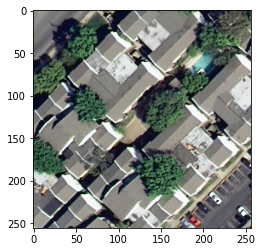

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : lots of cars are very closed to each other in the parking lot
Real Caption  2 : lots of cars parked in lines in the parking lot
Real Caption  3 : many cars are densely arranged in the parking lot
Real Caption  4 : it is a parking lot with many cars densely arranged
Real Caption  5 : many cars densely arranged in the parking lot
Predicted Caption: lots of cars parked in lines in the parking lot


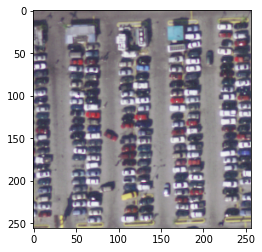

BLEU-1 score: 69.23077392578125
BLEU-2 score: 53.708614349365234
BLEU-3 score: 37.431888580322266
BLEU-4 score: 26.911090850830078
Real Caption  1 : it is a medium residential area with houses and plants
Real Caption  2 : a medium residential area with houses arranged neatly
Real Caption  3 : a medium residential area with houses arranged neatly and a road goes through
Real Caption  4 : many houses arranged neatly with plants surrounded in the medium residential area
Real Caption  5 : this is a medium residential area with a road goes through
Predicted Caption: lots of houses arranged neatly and some plants in the dense residential area


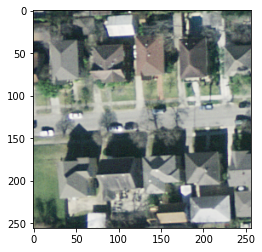

BLEU-1 score: 100.0
BLEU-2 score: 94.2809066772461
BLEU-3 score: 87.35804748535156
BLEU-4 score: 78.56293487548828
Real Caption  1 : this is a beach with blue green sea and white sands
Real Caption  2 : waves slapping a white sand beach throw up white foams
Real Caption  3 : a beautiful beach with some people and cars
Real Caption  4 : blue green sea and white sands with some people on the beach
Real Caption  5 : some plants and people on the beach
Predicted Caption: this is a beach with blue sea and white sands


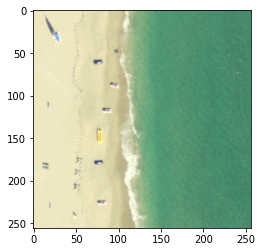

BLEU-1 score: 92.85713958740234
BLEU-2 score: 92.5820083618164
BLEU-3 score: 92.27587890625
BLEU-4 score: 91.9322738647461
Real Caption  1 : this is a part of a golf course with green turfs and some bunkers
Real Caption  2 : a part of a golf course with green turfs and some bunkers and a trail go through the turfs
Real Caption  3 : a part of a golf course with green turfs and some bunkers
Real Caption  4 : there are turfs and some bunkers and a trail go through the turfs in the golf course
Real Caption  5 : green turfs and some bunkers and a trail go through the turfs in the golf course
Predicted Caption: a part of a golf course with green turfs and some bunkers and trees


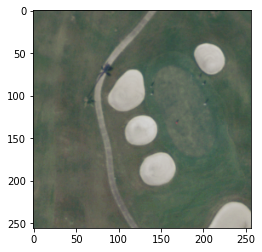

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : this is a part of a golf course with green turfs and some bunkers and trees
Real Caption  2 : a part of a golf course with green turfs and some bunkers and trees
Real Caption  3 : a part of a golf course with green turfs and some trees
Real Caption  4 : there are turfs and some bunkers and trees in the golf course
Real Caption  5 : green turfs and some bunkers and trees in the golf course
Predicted Caption: a part of a golf course with green turfs and some bunkers


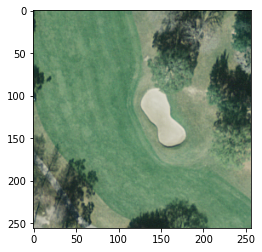

In [25]:
import matplotlib.pyplot as plt
import random
for rid in random.sample(list(val_dict.keys()),10):
    score1,score2,score3,score4,references,candidate=evaluate_bleu_img(transformer,rid,val_dict)
    print(f"BLEU-1 score: {score1*100}")
    print(f"BLEU-2 score: {score2*100}")
    print(f"BLEU-3 score: {score3*100}")
    print(f"BLEU-4 score: {score4*100}")
    for c in range(len(references[0])):
      print('Real Caption ',c+1,':',' '.join(references[0][c]))
    print ('Predicted Caption:', ' '.join(candidate[0]))
    image=image_path+str(rid)+'.tif'
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)
    plt.pause(0.001)

BLEU-1 score: 100.0
BLEU-2 score: 88.19171142578125
BLEU-3 score: 83.55496215820312
BLEU-4 score: 80.34284210205078
Real Caption  1 : an overpass with a road go across another two vertically
Real Caption  2 : an overpass with a road go across another two vertically with some cars on the roads
Real Caption  3 : an overpass with a road go across another two vertically with lawn surounded
Real Caption  4 : a road go across another two vertically with some cars on the roads
Real Caption  5 : a road go across another two with some cars on the roads
Predicted Caption: an overpass with a road go across another roads vertically


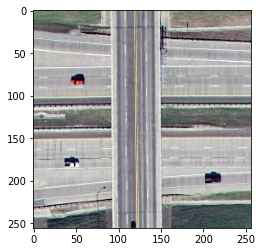

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : there is a piece of farmland
Real Caption  2 : there is a piece of cropland
Real Caption  3 : it is a piece of farmland
Real Caption  4 : it is a piece of cropland
Real Caption  5 : here is a piece of farmland
Predicted Caption: it is a piece of farmland


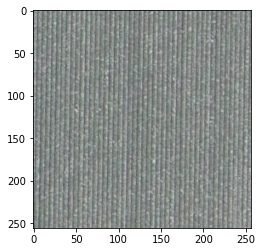

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : many mobile homes arranged in lines in the mobile home park
Real Caption  2 : many mobile homes are closed to each other in the mobile home park
Real Caption  3 : lots of mobile homes with some cars parked at the roadside in the mobile home park
Real Caption  4 : many mobile homes arranged in lines in the mobile home park and some roads go through this area
Real Caption  5 : lots of mobile homes are closed to each other and some roads go through this area
Predicted Caption: many mobile homes arranged in lines in the mobile home park and some roads go through this area


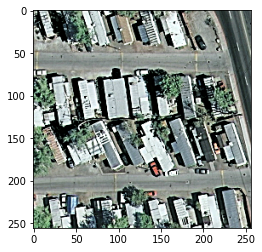

BLEU-1 score: 90.0
BLEU-2 score: 83.66600036621094
BLEU-3 score: 70.47298431396484
BLEU-4 score: 47.287078857421875
Real Caption  1 : it is a river with many trees on both banks of the river
Real Caption  2 : a river with lots of plants on both banks of the river
Real Caption  3 : green plants flourish on both banks of the river
Real Caption  4 : lots of green plants flourish on both banks of the river
Real Caption  5 : a river go through a dense forest
Predicted Caption: this is a dense forest with lots of green plants


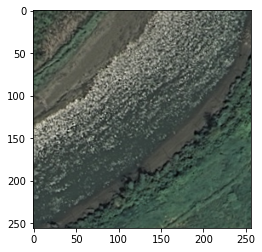

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : there is a piece of farmland
Real Caption  2 : there is a piece of cropland
Real Caption  3 : it is a piece of farmland
Real Caption  4 : it is a piece of cropland
Real Caption  5 : here is a piece of farmland
Predicted Caption: it is a piece of farmland


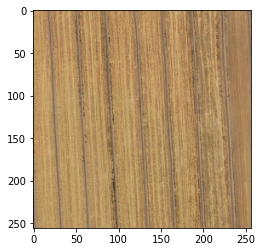

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : an intersection with a few cars on the road
Real Caption  2 : an intersection with some houses and plants at the corners
Real Caption  3 : an intersection only with some houses and plants at the corners
Real Caption  4 : an intersection with two roads vertical to each other
Real Caption  5 : an intersection with two roads vertical to each other
Predicted Caption: an intersection with some houses and plants at the corners


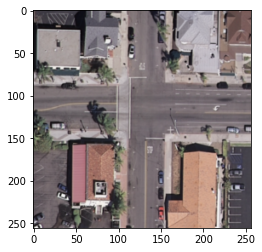

BLEU-1 score: 42.3240852355957
BLEU-2 score: 25.522384643554688
BLEU-3 score: 17.666616439819336
BLEU-4 score: 0.0
Real Caption  1 : it is a river with dense forest on both banks of the river and some boats moored to the bank
Real Caption  2 : a river with dense forest on both banks of the river and some boats moored to the bank
Real Caption  3 : green plants flourish on both banks of the river and some boats moored to the bank
Real Caption  4 : lots of green plants flourish on both banks of the river and some boats moored to the bank
Real Caption  5 : a river go through a dense forest and some boats moored to the bank
Predicted Caption: it is a straight runway with some white mark lines on it


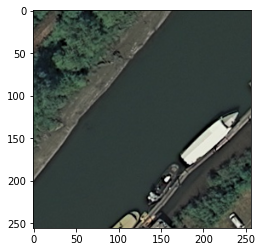

BLEU-1 score: 49.53588104248047
BLEU-2 score: 46.336570739746094
BLEU-3 score: 42.06832504272461
BLEU-4 score: 35.640262603759766
Real Caption  1 : there is a white airplane in the airport
Real Caption  2 : an airplane is stopped at the airport with some luggage cars beside it
Real Caption  3 : it is a white airplane stopped at the airport
Real Caption  4 : there is an airplane stopped at the airport
Real Caption  5 : an white airplane is stopped at the airport with some luggage cars surrounded it
Predicted Caption: two airplanes are stopped at the airport


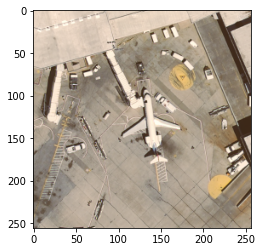

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : it is a straight runway with some mark lines on it
Real Caption  2 : a straight runway with some mark lines on it
Real Caption  3 : there are some mark lines on the straight runway
Real Caption  4 : it is a straight runway with some white mark lines on it
Real Caption  5 : a straight runway with some white mark lines on it
Predicted Caption: a straight runway with some white mark lines on it


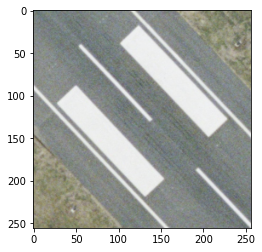

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0
Real Caption  1 : this is a part of a golf course with green turfs and trees
Real Caption  2 : a part of a golf course with green turfs and some bunkers and trees
Real Caption  3 : a part of a golf course with green turfs and some trees
Real Caption  4 : there are turfs and some bunkers and trees in the golf course
Real Caption  5 : green turfs and some bunkers with some trees in the golf course
Predicted Caption: a part of a golf course with green turfs and some bunkers


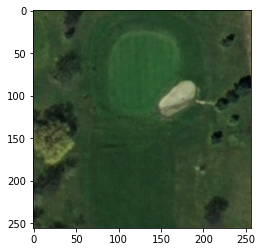

In [27]:
transformer.load_state_dict(torch.load("best_transformer"))
for rid in random.sample(list(test_dict.keys()),10):
    score1,score2,score3,score4,references,candidate=evaluate_bleu_img(transformer,rid,test_dict)
    print(f"BLEU-1 score: {score1*100}")
    print(f"BLEU-2 score: {score2*100}")
    print(f"BLEU-3 score: {score3*100}")
    print(f"BLEU-4 score: {score4*100}")
    for c in range(len(references[0])):
      print('Real Caption ',c+1,':',' '.join(references[0][c]))
    print ('Predicted Caption:', ' '.join(candidate[0]))
    image=image_path+str(rid)+'.tif'
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)
    plt.pause(0.001)